In [50]:
# Import packages
from pyomo.core import *
from pyomo.core.base.piecewise import Bound
from pyomo.environ import *
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pyomo.util.infeasible import log_infeasible_constraints
import gurobipy as gp
import time as zeit
from scipy.spatial import ConvexHull
from matplotlib import rc
from typing import List, Tuple, Optional, Dict
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import time

from itertools import product
from ppopt.mpmodel import MPModeler, VariableType
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.mp_solvers.solve_mpmiqp import solve_mpmiqp, mpmiqp_algorithm
from ppopt.plot import parametric_plot, parametric_plot_1D
from ppopt.mpmilp_program import MPMILP_Program

### Reported Solution

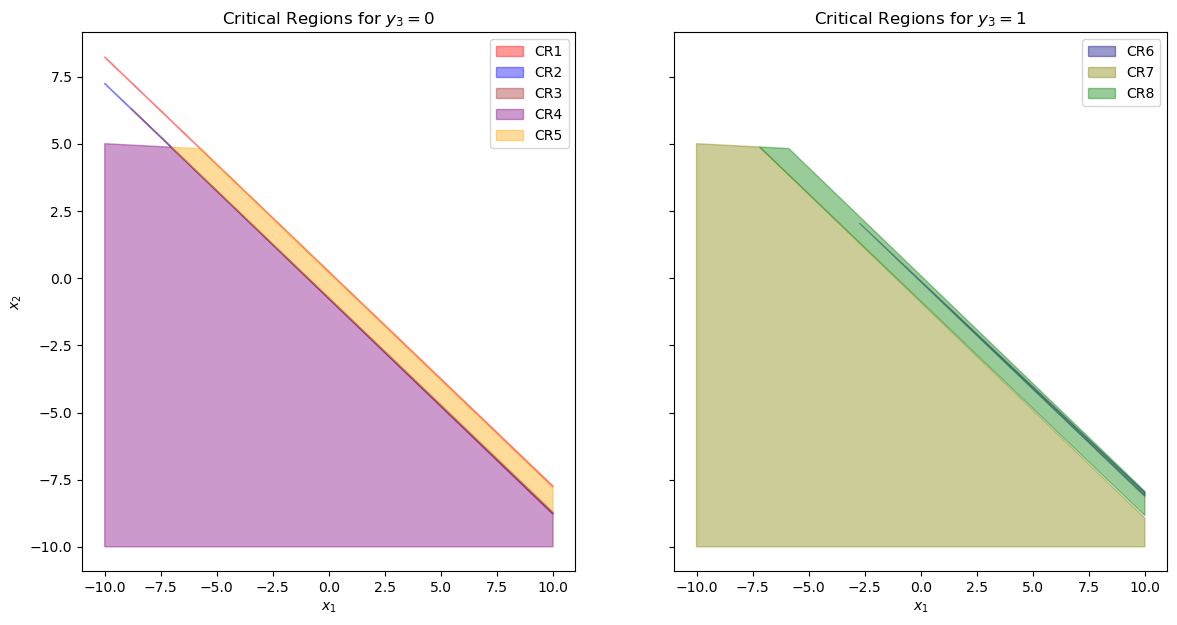

<Figure size 3840x2880 with 0 Axes>

In [51]:
def get_feasible_polygon(A, b):
    vertices = []
    for i in range(len(A)):
        for j in range(i + 1, len(A)):
            A_pair = np.array([A[i], A[j]])
            b_pair = np.array([b[i], b[j]])
            try:
                point = np.linalg.solve(A_pair, b_pair)
                if np.all(A @ point <= b + 1e-5):
                    vertices.append(point)
            except np.linalg.LinAlgError:
                continue
    if len(vertices) >= 3:
        vertices = np.array(vertices)
        hull = ConvexHull(vertices)
        return vertices[hull.vertices]
#Each region is defined as (A, b), where A @ [x1, x2] <= b
regions_binary_0 = [
    # Region 1
    (np.array([
        [-0.624, -0.780],
        [0.624, 0.781],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        -0.175,
        0.198,
        10,
        10,
        10
    ]))
    ,
    # Region 2
    (np.array([
        [0.624, 0.781],
        [-0.624, -0.780],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        -0.570,
        0.594,
        10,
        10,
        10
    ]))
    ,
    # Region 3
    (np.array([
        [-0.626, -0.780],
        [0.624, 0.781],
        [-0.626, -0.780],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        0.596,
        -0.570,
        0.594,
        10,
        10,
        10
    ]))
    ,
    # Region 4
    (np.array([
        [0.626, 0.780],
        [0.044, 0.999],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        -0.596,
        4.565,
        10,
        10,
        10
    ]))
    ,
    # Region 5
    (np.array([
        [0.044, 0.999],
        [0.626, 0.780],
        [-0.624, -0.781],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        4.565,
        0.175,
        0.570,
        10,
        10,
        10
    ]))
]
regions_binary_1 = [
    # Region 6
    (np.array([
        [0.626, 0.795],
        [-0.624, -0.781],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        -0.0787,
        0.102,
        10,
        10,
        10
    ]))
    ,
    # Region 7
    (np.array([
        [0.626, 0.779],
        [0.044, 0.999],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        -0.693,
        4.565,
        10,
        10,
        10
    ]))
    ,
    # Region 8
    (np.array([
        [0.626, 0.779],
        [0.044, 0.999],
        [-0.6241, -0.7814],
        [1.0, 0.0],
        [-1.0, 0.0],
        [0.0, -1.0]
    ]), np.array([
        0.0787,
        4.565,
        0.666,
        10,
        10,
        10
    ]))
]

colors_0 = ['red', 'blue', 'brown', 'purple', 'orange']
colors_1 = ['navy', 'olive', 'green']
labels_0 = [f"CR{i+1}" for i in range(5)]
labels_1 = [f"CR{i+6}" for i in range(3)]
# labels_0 = ['CR4','CR5']
# labels_1 = ['CR7','CR8']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# Plot binary = 0
for i, (A, b) in enumerate(regions_binary_0):
    polygon = get_feasible_polygon(A, b)
    if polygon is not None:
        ax1.fill(polygon[:, 0], polygon[:, 1], color=colors_0[i], alpha=0.4, label=labels_0[i])
ax1.set_title("Critical Regions for $y_3 = 0$")
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.legend()

# Plot binary = 1
for i, (A, b) in enumerate(regions_binary_1):
    polygon = get_feasible_polygon(A, b)
    if polygon is not None:
        ax2.fill(polygon[:, 0], polygon[:, 1], color=colors_1[i], alpha=0.4, label=labels_1[i])
ax2.set_title("Critical Regions for $y_3 = 1$")
ax2.set_xlabel('$x_1$')
ax2.legend()
#Resolution
plt.figure(dpi=600)

plt.tight_layout()
plt.show()

In [52]:
bilevelsolutions = [
    {'x1': -10.0, 'x2': 8.243277848911653, 'x3': 10.12804097311141, 'y1': 0, 'y2': 0, 'y3': 0},
    {'x1': -10.0, 'x2': 7.259923175416134, 'x3': 9.291421254801541, 'y1': 0, 'y2': 0, 'y3': 0},
    {'x1': -8.835315645013763, 'x2': 6.329368709972584, 'x3': 210.30649588289134, 'y1': 1, 'y2': 0, 'y3': 0},
    {'x1': -10.0, 'x2': 5.01001001001001, 'x3': 15.771171171171172, 'y1': 1, 'y2': 0, 'y3': 0},
    {'x1': -7.019712671388699, 'x2': 4.8787461036447475, 'x3': 8.519675660258194, 'y1': 0, 'y2': 0, 'y3': 0},
    {'x1': -2.7356147198215774, 'x2': 2.055087817117368, 'x3': 55.083426261499824, 'y1': 0, 'y2': 0, 'y3': 1},
    {'x1': -10.0, 'x2': 5.01001001001001, 'x3': 15.771171171171172, 'y1': 1, 'y2': 0, 'y3': 1},
    {'x1': -7.184630711925069, 'x2': 4.8860097610857895, 'x3': 8.920946510601105, 'y1': 0, 'y2': 0, 'y3': 1}
]

#Feasibility checks 

tol = 1e-10
for k, point in enumerate(bilevelsolutions):
    x1, x2, x3 = point['x1'], point['x2'], point['x3']
    y1, y2, y3 = point['y1'], point['y2'], point['y3']

    c1 = 6.4*x1 + 7.2*x2 + 2.5*x3
    c2 = -8*x1 - 4.9*x2 - 3.2*x3
    c3 = 3.3*x1 + 4.1*x2 + 0.02*x3 + 4*y1 + 4.5*y2 + 0.5*y3

    print(f"Critical Region {k}")
    print(f"  Constraint 1: {c1} <= 11.5  -> {'Pass' if c1 <= 11.5 + tol else 'Fail'}")
    print(f"  Constraint 2: {c2} <= 5    -> {'Pass' if c2 <= 5 + tol else 'Fail'}")
    print(f"  Constraint 3: {c3} <= 1    -> {'Pass' if c3 <= 1 + tol else 'Fail'}")
    print()

Critical Region 0
  Constraint 1: 20.67170294494243 <= 11.5  -> Fail
  Constraint 2: 7.198207426376378 <= 5    -> Fail
  Constraint 3: 1.0000000000000002 <= 1    -> Pass

Critical Region 1
  Constraint 1: 11.500000000000018 <= 11.5  -> Pass
  Constraint 2: 14.693828425096008 <= 5    -> Fail
  Constraint 3: -3.048486555697824 <= 1    -> Pass

Critical Region 2
  Constraint 1: 514.7916742909429 <= 11.5  -> Fail
  Constraint 2: -633.3121683440079 <= 5    -> Pass
  Constraint 3: 5.000000000000004 <= 1    -> Fail

Critical Region 3
  Constraint 1: 11.500000000000007 <= 11.5  -> Pass
  Constraint 2: 4.983203203203203 <= 5    -> Pass
  Constraint 3: -8.143535535535536 <= 1    -> Pass

Critical Region 4
  Constraint 1: 11.499999999999996 <= 11.5  -> Pass
  Constraint 2: 4.988883350424096 <= 5    -> Pass
  Constraint 3: -2.9917992774340783 <= 1    -> Pass

Critical Region 5
  Constraint 1: 134.99726373013652 <= 11.5  -> Fail
  Constraint 2: -164.4519765821019 <= 5    -> Pass
  Constraint 3: 0.9

### New Solution

In [53]:
m = MPModeler()

#Variables
x3 = m.add_var()
y1 = m.add_var(vtype = VariableType.binary)
y2 = m.add_var(vtype = VariableType.binary)

#Parameters
x1 = m.add_param()
x2 = m.add_param()
y3 = m.add_param()

#Constraints 
m.add_constr(6.4*x1 + 7.2*x2 + 2.5*x3 <= 11.5)
m.add_constr(-8*x1 - 4.9*x2 - 3.2*x3 <= 5)
m.add_constr(3.3*x1 + 4.1*x2 + 0.02*x3 + 4*y1 + 4.5*y2 + 0.5*y3 <= 1)

m.add_constr(x1 >= -10)
m.add_constr(x2 >= -10)
m.add_constr(x1 <= 10)
m.add_constr(x2 <= 10)
m.add_constr(y3 <= 1)
m.add_constr(y3 >= 0)

m.set_objective(-x1+x2-2*x3-y1+5*y2+y3)

#Formulating and solving mpp
prog = m.formulate_problem()
prog.process_constraints()
solution = solve_mpmiqp(prog, mpmiqp_algo = mpmiqp_algorithm.enumerate, cont_algo=mpqp_algorithm.combinatorial)

print(f"Number of critical regions: {len(solution)}")

Number of critical regions: 8


In [54]:
names = [i.name for i in m.variables]

In [55]:
names

['x_0', 'y_1', 'y_2']

In [56]:
#Function to compile parameterization matrices into a list
def extract_matrices(region_list):

    matrices = []
    
    for k in range(len(region_list)):
        A = region_list[k].A
        b = region_list[k].b
        C = region_list[k].C
        d = region_list[k].d
        E = region_list[k].E
        f = region_list[k].f
        
        matrices.append((A, b, C, d, E, f))  
    
    return matrices

#Extracting data from mp model
region_list = solution.critical_regions
data = extract_matrices(region_list)
theta = m.parameters
# theta_names = [var.name.split('[')[0] for var in m.parameters]
theta_names = [i.name for i in m.parameters]
variables = m.variables 
# variable_names = [var.name.split('[')[0] for var in m.variables]
variable_names = [i.name for i in m.variables]
#Extracting y data from mp model
y_values = []
for k in range(len(solution)):
    binary = solution.critical_regions[k].y_fixation
    y_values.append(binary)

In [57]:
def ULP(k):

    m = ConcreteModel()
    A, b, C, d, E, f = data[k]
    
    #Set 
    m.b = Set(initialize = range(len(E)))
    
    #Variables
    m.x1 = Var(within=Reals, bounds=[-10,10])
    m.x2 = Var(within=Reals, bounds=[-10,10])
    m.x3 = Var(within=Reals)

    m.y1 = Param(initialize=y_values[k][0])
    m.y2 = Param(initialize=y_values[k][1])
    m.y3 = Var(within=Reals, bounds=[0,1])

    m.upper_obj = Var(within=Reals)

    def upper_objective(m):
        return m.upper_obj == 4*m.x1 - m.x2 +m.x3 + 5*m.y1 - 6*m.y3
    m.upper_objective = Constraint(rule = upper_objective)

    ##Constraints from lower level

    def equality_constraint_x3(m):
        return m.x3 == A[0][0] * m.x1 + A[0][1] * m.x2 + A[0][2] * m.y3 + b[0][0]
    m.equality_constraint_x3 = Constraint(rule = equality_constraint_x3)

    def inequality_constraints(m, b):
        return E[b][0] * m.x1 + E[b][1] * m.x2 + E[b][2] * m.y3 <= f[b][0]
    m.inequality_constraints = Constraint(m.b, rule = inequality_constraints)

    #Objective   
    m.objective = Objective(expr= m.upper_obj, sense = minimize)

    result = SolverFactory('gurobi').solve(m, tee=False)

    return m.x1.value, m.x2.value, m.x3.value, m.y1.value, m.y2.value, m.y3.value, m.upper_obj()

new_bilevelsolutions = []
for k in range(len(solution)):
    x1, x2, x3, y1, y2, y3, upper_obj = ULP(k)
    print(f"k={k}, x1={x1}, x2={x2}, x3={x3}, y1={y1}, y2={y2}, y3={y3}, upper_obj={upper_obj}")
    new_bilevelsolutions.append({
        'k': k,
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'y1': y1,
        'y2': y2,
        'y3': y3,
        'upper_obj': upper_obj
    })

k=0, x1=-10.0, x2=5.0139017608897145, x3=15.759962928637627, y1=0, y2=0, y3=1.0, upper_obj=-35.25393883225209
k=1, x1=-5.885330160474964, x2=4.830858060892307, x3=5.753573995446118, y1=0, y2=0, y3=1.0, upper_obj=-28.618604707346044
k=2, x1=-10.0, x2=5.0139017608897145, x3=15.759962928637627, y1=0, y2=1, y3=1.0, upper_obj=-35.25393883225209
k=3, x1=-7.3516195469013335, x2=4.896086875117021, x3=9.319415839730823, y1=0, y2=1, y3=1.0, upper_obj=-30.98314922299153
k=4, x1=-10.0, x2=5.0139017608897145, x3=15.759962928637627, y1=1, y2=0, y3=1.0, upper_obj=-30.25393883225209
k=5, x1=-7.18869850396506, x2=4.888839229092046, x3=8.923211190365805, y1=1, y2=0, y3=1.0, upper_obj=-25.72042205458648
k=6, x1=-10.0, x2=5.0139017608897145, x3=15.759962928637627, y1=1, y2=1, y3=1.0, upper_obj=-30.25393883225209
k=7, x1=-8.654987890391466, x2=4.95406804331679, x3=12.48905303465017, y1=1, y2=1, y3=1.0, upper_obj=-28.08496657023248


In [58]:
#Feasibility checks 

tol = 1e-10
for k, point in enumerate(new_bilevelsolutions):
    x1, x2, x3 = point['x1'], point['x2'], point['x3']
    y1, y2, y3 = point['y1'], point['y2'], point['y3']

    c1 = 6.4*x1 + 7.2*x2 + 2.5*x3
    c2 = -8*x1 - 4.9*x2 - 3.2*x3
    c3 = 3.3*x1 + 4.1*x2 + 0.02*x3 + 4*y1 + 4.5*y2 + 0.5*y3

    print(f"k={k}")
    print(f"  Constraint 1: {c1} <= 11.5  -> {'Pass' if c1 <= 11.5 + tol else 'Fail'}")
    print(f"  Constraint 2: {c2} <= 5    -> {'Pass' if c2 <= 5 + tol else 'Fail'}")
    print(f"  Constraint 3: {c3} <= 1    -> {'Pass' if c3 <= 1 + tol else 'Fail'}")
    print()

k=0
  Constraint 1: 11.500000000000014 <= 11.5  -> Pass
  Constraint 2: 4.999999999999993 <= 5    -> Pass
  Constraint 3: -11.627803521779422 <= 1    -> Pass

k=1
  Constraint 1: 11.500000000000135 <= 11.5  -> Pass
  Constraint 2: 4.999999999999822 <= 5    -> Pass
  Constraint 3: 1.0000000000000022 <= 1    -> Pass

k=2
  Constraint 1: 11.500000000000014 <= 11.5  -> Pass
  Constraint 2: 4.999999999999993 <= 5    -> Pass
  Constraint 3: -7.127803521779422 <= 1    -> Pass

k=3
  Constraint 1: 11.500000000001073 <= 11.5  -> Pass
  Constraint 2: 4.999999999998625 <= 5    -> Pass
  Constraint 3: 1.0000000000000036 <= 1    -> Pass

k=4
  Constraint 1: 11.500000000000014 <= 11.5  -> Pass
  Constraint 2: 4.999999999999993 <= 5    -> Pass
  Constraint 3: -7.627803521779422 <= 1    -> Pass

k=5
  Constraint 1: 11.500000000000853 <= 11.5  -> Pass
  Constraint 2: 4.999999999998877 <= 5    -> Pass
  Constraint 3: 1.0000000000000022 <= 1    -> Pass

k=6
  Constraint 1: 11.500000000000014 <= 11.5  -> 

In [59]:
# -------------------------
# Correct 2D projection by fixing other parameters
# -------------------------

def project_polytope_2d(A: np.ndarray, b: np.ndarray,
                        active_dims: Tuple[int, int],
                        fixed_values: Dict[int, float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Project a high-D polytope Ax <= b onto 2D by fixing other dimensions.

    Args:
        A: Full constraint matrix (m x n)
        b: RHS vector (m,) or (m,1)
        active_dims: Tuple of dimensions to project onto (e.g., (0, 3))
        fixed_values: Dict mapping dimension index to fixed value
                     e.g., {1: 0.5, 2: -1.0, 4: 2.0}

    Returns:
        A_2d, b_2d: 2D constraint system for the projection
    """
    i, j = active_dims

    # Ensure arrays have proper shapes
    A = np.asarray(A)
    b = np.asarray(b).flatten()  # Ensure b is 1D

    print(
        f"DEBUG project_polytope_2d: A.shape = {A.shape}, b.shape = {b.shape}")

    # Start with original constraints
    A_proj = A[:, [i, j]].copy()  # Extract columns for active dimensions
    b_proj = b.copy()

    print(
        f"DEBUG: Initial A_proj.shape = {A_proj.shape}, b_proj.shape = {b_proj.shape}")

    # Subtract the contribution of fixed dimensions
    for dim_idx, fixed_val in fixed_values.items():
        if dim_idx != i and dim_idx != j:  # Don't modify active dimensions
            A_col = A[:, dim_idx].flatten()  # Ensure column is 1D
            print(f"DEBUG: dim_idx={dim_idx}, fixed_val={fixed_val}")
            print(
                f"DEBUG: A_col.shape = {A_col.shape}, b_proj.shape = {b_proj.shape}")

            b_proj = b_proj - A_col * fixed_val
            print(f"DEBUG: After subtraction, b_proj.shape = {b_proj.shape}")

    return A_proj, b_proj

In [60]:
# -------------------------
# Improved vertex enumeration with feasibility check
# -------------------------
def vertex_enumeration_2d_robust(A: np.ndarray, b: np.ndarray, eps: float = 1e-8) -> List[np.ndarray]:
    """
    Robust 2D vertex enumeration with proper feasibility checking.
    """
    if A.shape[1] != 2:
        raise ValueError("This function only works for 2D problems")

    num_constraints = A.shape[0]
    vertices = []

    # Find all pairwise intersections
    for i in range(num_constraints):
        for j in range(i + 1, num_constraints):
            # Solve 2x2 system: A[i]x = b[i], A[j]x = b[j]
            A_pair = np.array([A[i], A[j]])
            b_pair = np.array([b[i], b[j]])

            try:
                # Check if lines are parallel
                det = np.linalg.det(A_pair)
                if abs(det) < eps:
                    continue  # Lines are parallel or nearly parallel

                # Find intersection point
                vertex = np.linalg.solve(A_pair, b_pair)

                # Check if this point satisfies ALL constraints (is feasible)
                if np.all(A @ vertex <= b + eps):
                    # Check if it's not already in our list
                    is_duplicate = any(np.allclose(vertex, v, atol=eps)
                                       for v in vertices)
                    if not is_duplicate:
                        vertices.append(vertex)

            except np.linalg.LinAlgError:
                continue  # Singular system, skip

    return vertices

In [61]:
# -------------------------
# Sort vertices counter-clockwise
# -------------------------
def sort_vertices_ccw(vertices: List[np.ndarray]) -> np.ndarray:
    """Sort vertices counter-clockwise around their centroid."""
    if len(vertices) < 3:
        return np.array(vertices) if vertices else np.array([])

    pts = np.array(vertices)
    center = pts.mean(axis=0)
    angles = np.arctan2(pts[:, 1] - center[1], pts[:, 0] - center[0])
    return pts[np.argsort(angles)]

In [62]:
def gen_vertices_projected_fixed(
    solution_or_cr,
    active_dims: Tuple[int, int],
    fixed_values: Dict[int, float]
) -> List[np.ndarray]:
    """
    Project critical regions to 2D by fixing specified parameter values.

    Args:
        solution_or_cr: multiparametric solution object OR a single critical region
        active_dims: Tuple of two theta indices to project onto
        fixed_values: Dict of {dimension: value} for fixed parameters

    Returns:
        List of 2D vertex arrays (one per critical region)
    """
    from collections.abc import Iterable

    # Determine if input is the whole solution or a single critical region
    if hasattr(solution_or_cr, 'critical_regions'):
        critical_regions = solution_or_cr.critical_regions
        n_dims = solution_or_cr.theta_dim()
    else:
        # Single critical region
        critical_regions = [solution_or_cr]
        n_dims = solution_or_cr.E.shape[1]

    i, j = active_dims

    # Validate active dimensions
    if max(i, j) >= n_dims:
        raise ValueError(
            f"Active dimensions {active_dims} exceed solution dimension {n_dims}")

    # Check that we're fixing the right number of dimensions
    expected_fixed = set(range(n_dims)) - {i, j}
    provided_fixed = set(fixed_values.keys())

    if expected_fixed != provided_fixed:
        missing = expected_fixed - provided_fixed
        extra = provided_fixed - expected_fixed
        msg = f"Dimension mismatch in fixed values.\n"
        if missing:
            msg += f"Missing fixed values for dimensions: {missing}\n"
        if extra:
            msg += f"Extra fixed values for dimensions: {extra}"
        raise ValueError(msg)

    polygons_2d = []

    for cr_idx, cr in enumerate(critical_regions):
        print(f"Processing critical region {cr_idx}")

        A_full = cr.E
        b_full = cr.f

        if hasattr(A_full, 'toarray'):
            A_full = A_full.toarray()
        if hasattr(b_full, 'toarray'):
            b_full = b_full.toarray()

        A_full = np.asarray(A_full)
        b_full = np.asarray(b_full).flatten()

        print(f"  A_full.shape: {A_full.shape}, b_full.shape: {b_full.shape}")

        try:
            A_2d, b_2d = project_polytope_2d(
                A_full, b_full, active_dims, fixed_values)

            vertices_2d = vertex_enumeration_2d_robust(A_2d, b_2d)

            if len(vertices_2d) >= 3:
                sorted_vertices = sort_vertices_ccw(vertices_2d)
                polygons_2d.append(sorted_vertices)
                print(f"  Added polygon with {len(vertices_2d)} vertices")
            else:
                print(f"  Skipped region with {len(vertices_2d)} vertices")

        except Exception as e:
            print(f"  Error processing region {cr_idx}: {e}")
            continue

    print(f"Total valid polygons: {len(polygons_2d)}")
    return polygons_2d

In [63]:
def parametric_plot_2d_projection_fixed(
    solution,
    active_dims: Tuple[int, int],
    fixed_values: Dict[int, float],
    cr_indices: Optional[List[int]] = None,
    save_path: Optional[str] = None,
    save_format: str = 'png',
    show: bool = True,
    seed: Optional[int] = None,
    title: Optional[str] = None
) -> None:
    """
    Plot 2D projection of parametric solution with fixed parameter values.

    Args:
        solution: multiparametric solution object
        active_dims: Tuple of dimensions to plot (e.g., (0, 3))
        fixed_values: Dict of fixed parameter values
        cr_indices: List of critical region indices to plot (optional)
        save_path: Optional path to save plot
        save_format: Format to save figure
        show: Whether to display the plot
        seed: Random seed for colors
        title: Optional plot title
    """
    try:
        # Generate polygons
        polygons_2d = []

        if cr_indices is not None:
            for idx in cr_indices:
                polys = gen_vertices_projected_fixed(
                    solution.critical_regions[idx],
                    active_dims,
                    fixed_values
                )
                polygons_2d.extend(polys)
        else:
            polygons_2d = gen_vertices_projected_fixed(
                solution, active_dims, fixed_values)

        if not polygons_2d:
            print("No valid polygons found for the given fixed values.")
            return

        fig, ax = plt.subplots(figsize=(10, 6))

        if seed is None:
            seed = int(time.time())
        rng = np.random.default_rng(seed)
        colors = rng.random(len(polygons_2d))

        patches = [Polygon(poly) for poly in polygons_2d]
        patch_collection = PatchCollection(patches, cmap='tab20',
                                           alpha=0.7, edgecolors='black', linewidths=0.8)
        patch_collection.set_array(colors)
        ax.add_collection(patch_collection)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        # Create title with fixed values if not provided
        ax.set_title('Critical Regions with y3 = 1')

        ax.grid(True, alpha=0.3)
        ax.autoscale()
        ax.margins(0.05)

        if save_path:
            plt.savefig(f"{save_path}.{save_format}", dpi=300, format=save_format,
                        bbox_inches='tight')
        if show:
            plt.rcdefaults()
            # plt.legend()
            plt.show()

        print(f"Successfully plotted {len(polygons_2d)} critical regions")

    except Exception as e:
        print(f"Error in plotting: {e}")
        import traceback
        traceback.print_exc()

Processing critical region 0
  A_full.shape: (7, 3), b_full.shape: (7,)
DEBUG project_polytope_2d: A.shape = (7, 3), b.shape = (7,)
DEBUG: Initial A_proj.shape = (7, 2), b_proj.shape = (7,)
DEBUG: dim_idx=2, fixed_val=1
DEBUG: A_col.shape = (7,), b_proj.shape = (7,)
DEBUG: After subtraction, b_proj.shape = (7,)
  Added polygon with 5 vertices
Processing critical region 1
  A_full.shape: (5, 3), b_full.shape: (5,)
DEBUG project_polytope_2d: A.shape = (5, 3), b.shape = (5,)
DEBUG: Initial A_proj.shape = (5, 2), b_proj.shape = (5,)
DEBUG: dim_idx=2, fixed_val=1
DEBUG: A_col.shape = (5,), b_proj.shape = (5,)
DEBUG: After subtraction, b_proj.shape = (5,)
  Added polygon with 3 vertices
Processing critical region 2
  A_full.shape: (7, 3), b_full.shape: (7,)
DEBUG project_polytope_2d: A.shape = (7, 3), b.shape = (7,)
DEBUG: Initial A_proj.shape = (7, 2), b_proj.shape = (7,)
DEBUG: dim_idx=2, fixed_val=1
DEBUG: A_col.shape = (7,), b_proj.shape = (7,)
DEBUG: After subtraction, b_proj.shape = (7

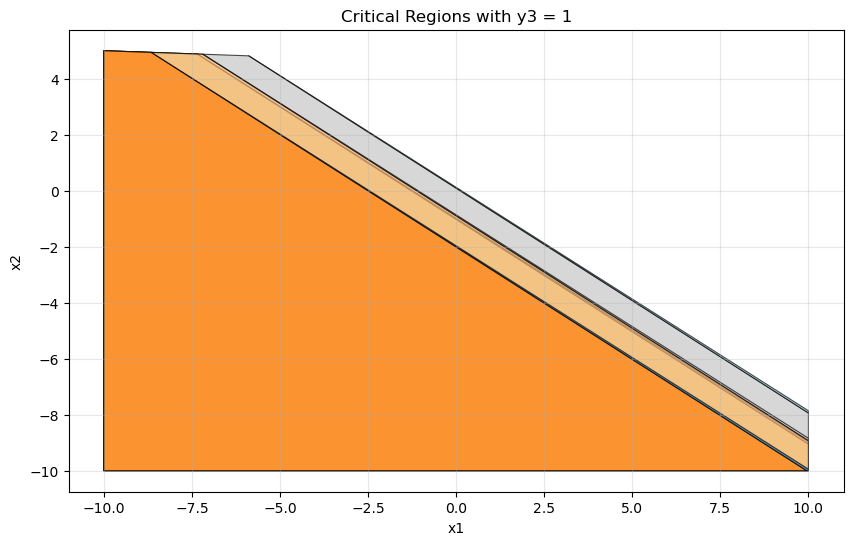

Successfully plotted 8 critical regions


In [64]:
n_dims = solution.theta_dim()
active_dims = (0, 1)

parametric_plot_2d_projection_fixed(
    solution, active_dims, {2:1})